In [2]:
%matplotlib inline
from pyiem.util import get_dbconn
from pandas.io.sql import read_sql
asos_pgconn = get_dbconn('asos')
acursor = asos_pgconn.cursor()

today = read_sql("""SELECT date(valid + '10 minutes'::interval) as date,
  extract(hour from valid + '10 minutes'::interval) as hr
  , min(round(tmpf::numeric,0)) as tmpf from alldata
  where station = 'DSM' and valid > '2018-05-25 23:50' 
  and valid < '2018-05-26 23:10' and tmpf is not null
  GROUP by date, hr ORDER by date, hr ASC
  """, asos_pgconn, index_col=None)
today['last_date'] = None
today['last_tmpf'] = None
today['last_low'] = None
today

,date,hr,tmpf,last_date,last_tmpf,last_low
0,2018-05-26,0.0,77.0,None,None,None
1,2018-05-26,1.0,75.0,None,None,None
2,2018-05-26,2.0,74.0,None,None,None
3,2018-05-26,3.0,73.0,None,None,None
4,2018-05-26,4.0,72.0,None,None,None
5,2018-05-26,5.0,70.0,None,None,None
6,2018-05-26,6.0,69.0,None,None,None
7,2018-05-26,7.0,70.0,None,None,None
8,2018-05-26,8.0,73.0,None,None,None
9,2018-05-26,9.0,76.0,None,None,None


In [2]:
import mx.DateTime
thursdays =[]
for yr in range(1880,2015):
  nov1 = mx.DateTime.DateTime(yr, 2, 14)
  turkey = nov1
  #turkey = nov1 + mx.DateTime.RelativeDateTime(weekday=(mx.DateTime.Thursday,4))
  thursdays.append(turkey.strftime("%Y-%m-%d"))

In [3]:
COOP = get_dbconn('coop', user='nobody')
ccursor = COOP.cursor()
dates = []
highs = []
for idx, row in today.iterrows():
    hr = row['hr']
    print("Processing hour: %s" % (hr, ))
    acursor.execute("""
    SELECT valid, tmpf from alldata WHERE 
    extract(hour from valid + '10 minutes') = %s and station = 'DSM' 
    and round(tmpf::numeric, 0) >= %s
    and (valid + '10 minutes'::interval) < %s and extract(month from valid) = 5
    ORDER by valid DESC LIMIT 1
    """, (hr, row['tmpf'], row['date']))
    row = acursor.fetchone()
    if row is not None:
        today.at[idx, 'last_tmpf'] = row[1]
        today.at[idx, 'last_date'] = row[0]
    
        ccursor.execute("""
        SELECT high from alldata_ia where station = 'IA2203'
        and day = %s
        """, (row[0].strftime("%Y-%m-%d"),))
        row2 = ccursor.fetchone()
        today.at[idx, 'last_low'] = row2[0]

today

Processing hour: 0.0
Processing hour: 1.0
Processing hour: 2.0
Processing hour: 3.0
Processing hour: 4.0
Processing hour: 5.0
Processing hour: 6.0
Processing hour: 7.0
Processing hour: 8.0
Processing hour: 9.0
Processing hour: 10.0
Processing hour: 11.0
Processing hour: 12.0
Processing hour: 13.0
Processing hour: 14.0
Processing hour: 15.0
Processing hour: 16.0
Processing hour: 17.0
Processing hour: 18.0
Processing hour: 19.0
Processing hour: 20.0
Processing hour: 21.0
Processing hour: 22.0
Processing hour: 23.0


,date,hr,tmpf,last_date,last_tmpf,last_low
0,2018-05-26,0.0,77.0,2017-05-15 23:54:00-05:00,77,91
1,2018-05-26,1.0,75.0,2017-05-16 00:54:00-05:00,77,89
2,2018-05-26,2.0,74.0,2017-05-16 01:54:00-05:00,75.9,89
3,2018-05-26,3.0,73.0,2017-05-16 02:54:00-05:00,75.9,89
4,2018-05-26,4.0,72.0,2018-05-24 03:54:00-05:00,72,88
5,2018-05-26,5.0,70.0,2017-05-16 04:54:00-05:00,73.9,89
6,2018-05-26,6.0,69.0,2018-05-25 05:54:00-05:00,69.1,88
7,2018-05-26,7.0,70.0,2017-05-16 06:54:00-05:00,71.1,89
8,2018-05-26,8.0,73.0,2017-05-16 07:54:00-05:00,73,89
9,2018-05-26,9.0,76.0,2018-05-24 08:54:00-05:00,75.9,88


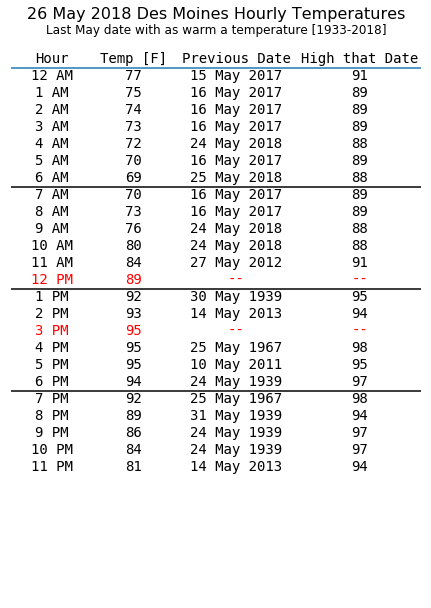

In [6]:
import datetime
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
monofont = FontProperties(family='monospace')
monofont.set_size(14)

(fig, ax) = plt.subplots(1,1, figsize=(6,9))
ax.set_position([0.02, 0.02, 0.95, 0.9])

ax.text(0.5, 0.99, '26 May 2018 Des Moines Hourly Temperatures', ha='center', size=16)
ax.text(0.5, 0.96, 'Last May date with as warm a temperature [1933-2018]',
        ha='center', size=12)

columns = [0.1, 0.3, 0.55, 0.85]
ax.text(columns[0], 0.90, 'Hour', ha='center', fontproperties=monofont)
ax.text(columns[1], 0.90, 'Temp [F]', ha='center', fontproperties=monofont)
ax.text(columns[2], 0.90, 'Previous Date', ha='center', fontproperties=monofont)
ax.text(columns[3], 0.90, 'High that Date', ha='center', fontproperties=monofont)

ax.plot([0.,1.], [0.89,0.89])

y = 0.865
for idx, row in today.iterrows():
    hr = row['hr']
    ts = datetime.datetime(row['date'].year, row['date'].month,
                           row['date'].day, int(hr))
    color = 'k' if row['last_date'] is not None else 'r'
    fmt = "%b %-d %-I %p" if hr == 0 and idx > 0 else "%-I %p"
    ax.text(columns[0], y, "%s" % (ts.strftime(fmt),), ha='center', color=color,
           fontproperties=monofont)
    ax.text(columns[1], y, "%.0f" % (row['tmpf'],), ha='center', color=color,
           fontproperties=monofont)
    lastdate = '--' if row['last_date'] is None else row['last_date'].strftime("%-d %b %Y")
    ax.text(columns[2], y, lastdate, ha='center', color=color,
           fontproperties=monofont)
    lasthigh = '--' if row['last_low'] is None else row['last_low']
    ax.text(columns[3], y, lasthigh, ha='center', color=color,
           fontproperties=monofont)
    if int(hr) % 6 == 0 and idx > 0:
        ax.plot([0,1], [y-0.01,y-0.01], color='k')
    y -= 0.035

ax.set_ylim(-0.2,1)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_xlim(0,1)
ax.axis('off')
    
fig.savefig('test.png')
